In [88]:
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, Input, MaxPooling2D, Dropout, Convolution2D
from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle
# from imgaug import augmenters as iaa
import matplotlib.pyplot as plt
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [89]:
# Define the column names for csv file
column_names = ['Center', 'Left', 'Right', 'Steering', 'Throttle', 'Brake', 'Speed']
# Load the csv file
data = pd.read_csv('driving_log.csv', header=None, names=column_names)


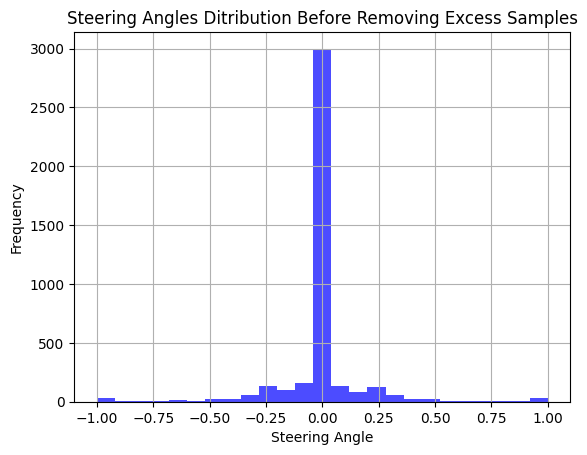

Removing 2590 samples
Remaining 1463 samples


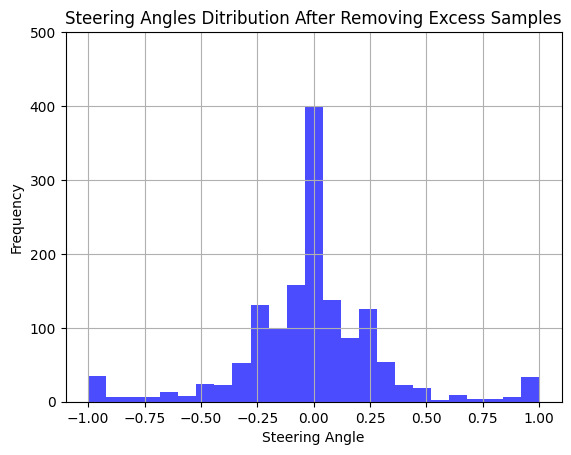

In [90]:
steering_angles = data['Steering']
num_bins = 25
samples_per_bin = 400

hist, bins, _ = plt.hist(steering_angles, bins=num_bins, color='blue', alpha=0.7)
plt.title("Steering Angles Ditribution Before Removing Excess Samples")
plt.xlabel("Steering Angle")
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

remove_list = []
for i in range(num_bins):
    list_ = []
    for j in range(len(data['Steering'])):
        # Check the steering angle value, if it falls within a bin range, then add them together
        if data['Steering'][j] >= bins[i] and data['Steering'][j] <= bins[i+1]:
            list_.append(j)
    list_ = shuffle(list_)

    # If the number of samples in the bin is greater than the samples_per_bin,
    # remove the excess samples
    list_ = list_[samples_per_bin:]
    remove_list.extend(list_)

print("Removing %d samples" % len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print("Remaining %d samples" % len(data))

hist, bins, _ = plt.hist(data['Steering'], bins=num_bins, color='blue', alpha=0.7)
plt.ylim(0, 500)
plt.title("Steering Angles Ditribution After Removing Excess Samples")
plt.xlabel("Steering Angle")
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Because after removing excess samples, the index of the data is not continuous, 
# so we need to reset the index
data.reset_index(drop=True, inplace=True)

In [91]:
def load_images_and_steering_angles(data):
    image_paths = []
    steering_angles = []
    for i in range(len(data)):
        # Load images with path validation
        center_path = data['Center'][i].strip()
        left_path = data['Left'][i].strip()
        right_path = data['Right'][i].strip()


        image_paths.extend([center_path, left_path, right_path])
        steering_angles.extend([
            data['Steering'][i],
            data['Steering'][i] + 0.3,  # Left image adjustment
            data['Steering'][i] - 0.3   # Right image adjustment
        ])

    return np.array(image_paths), np.array(steering_angles)

In [92]:
image_paths, steerings = load_images_and_steering_angles(data)


In [161]:
X_train, x_test, y_train, y_test = train_test_split(image_paths, steerings, test_size=0.2, random_state=42)

In [113]:
def augment_image(img_path, steering_angle):
    # Load the image
    img = cv2.imread(img_path.strip())
    if img is None:
        raise ValueError(f"Image not found or invalid path: {img_path}")
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Random flip (50% chance)
    if random.random() > 0.5:
        img = cv2.flip(img, 1)
        steering_angle = -steering_angle
    
    # Random brightness (HSV space)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hsv[:, :, 2] = hsv[:, :, 2] * random.uniform(0.4, 1.2)
    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    
    # Random shadow (top or bottom)
    if random.random() > 0.5:
        h, w = img.shape[:2]
        [x1, x2] = np.random.choice(w, 2, replace=False)
        m = np.zeros_like(img[:, :, 0])
        m.fill(0)
        y1, y2 = 0, h
        poly = np.array([[[x1, y1], [x2, y1], [x2, y2], [x1, y2]]], dtype=np.int32)
        cv2.fillPoly(m, poly, 255)
        img = np.where(m[..., None] == 255, img * 0.5, img)
    
    # Random translation (affects steering angle)
    if random.random() > 0.5:
        tx = 100 * (random.random() - 0.5)  # -50 to +50 pixels
        steering_angle += tx * 0.002  # Compensate steering
        M = np.float32([[1, 0, tx], [0, 1, 0]])
        img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
    
    return img, steering_angle

In [147]:
def preprocess_image(img):
    # Ensure the image is in uint8 format
    if img.dtype != np.uint8:
        img = (img * 255).astype(np.uint8)  # Scale and convert to uint8 if needed
        
    img = img[60:135, :, :]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img / 255
    return img

In [148]:
def batch_generator(image_paths, steering_angles, batch_size=32, is_training=True):
    num_images = len(image_paths)

    while True:
        batch_images = []
        batch_angles = []

        for i in range(batch_size):
            random_index = random.randint(0, num_images - 1)

            if is_training:
                image, angle = augment_image(image_paths[random_index], steering_angles[random_index])
            else:
                image = cv2.imread(image_paths[random_index])
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                angle = steering_angles[random_index]

            # print(image)
            image = preprocess_image(image)
            

            batch_images.append(image)
            batch_angles.append(angle)

        # Yields the batch as a tuple (batch_images, batch_angles).
        # The yield keyword is used to create a Python generator. 
        # Instead of returning all the data at once (like return), 
        # it produces one batch at a time and pauses execution until the next batch is requested. 
        # This is memory-efficient, especially when working with large datasets.
        yield (np.asarray(batch_images), np.asarray(batch_angles))

In [154]:
def enhanced_nvidia_model():
    model = Sequential([
        # Convolutional layers with more filters
        Conv2D(24, (5,5), strides=(2,2), activation='elu', input_shape=(66, 200, 3)),
        Conv2D(36, (5,5), strides=(2,2), activation='elu'),
        Conv2D(48, (5,5), strides=(2,2), activation='elu'),
        Conv2D(64, (5,5), activation='elu'),
        # Dense layers with batch normalization
        Flatten(),
        Dense(100, activation='elu'), 
        Dense(50, activation='elu'),
        Dense(10, activation='elu'),
        Dense(1)
    ])
    return model

d:\Hoc Tap\AllThingsOfCPA\Sem7\CVI\Python_Venvs\Venv_for_Py_3.12\tf_env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 129s 424ms/step - loss: 0.4255 - val_loss: 0.1355
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 111s 373ms/step - loss: 0.1499 - val_loss: 0.1079
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 125s 417ms/step - loss: 0.1245 - val_loss: 0.0804
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 122s 408ms/step - loss: 0.1106 - val_loss: 0.0746
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 110s 366ms/step - loss: 0.0963 - val_loss: 0.0592
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 102s 341ms/step - loss: 0.0921 - val_loss: 0.0574
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 101s 336ms/step - loss: 0.0866 - val_loss: 0.0547
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 101s 337ms/step - loss: 0.0841 - val_loss: 0.0485
Epoch 9/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 109s 365ms/step - loss: 0.0809 - val_loss: 0.0564
Epoch 10/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 101s 336ms/step - loss: 0.0782 - val_loss: 0.0515


 Model saved as model.h5


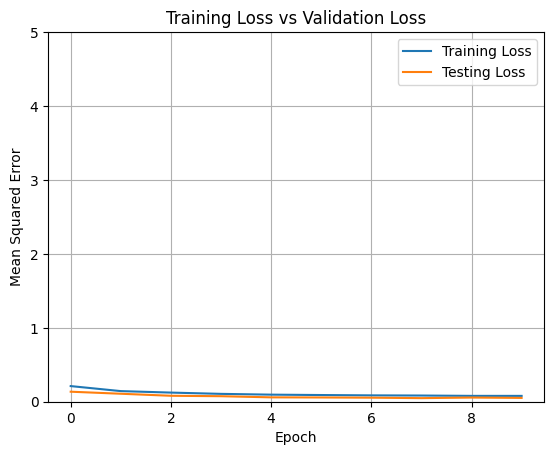

In [160]:
net = enhanced_nvidia_model()
net.compile(loss='mse', optimizer=Adam(learning_rate=0.001))

H = net.fit(batch_generator(X_train, y_train, batch_size=100, is_training=True), steps_per_epoch=300, epochs=10, validation_data=batch_generator(x_test, y_test, batch_size=100, is_training=False), validation_steps=200, verbose=1, shuffle=1)

# Save the model
net.save('model.h5')
print(" Model saved as model.h5")

# Plot training vs validation loss
plt.plot(H.history['loss'], label='Training Loss')
plt.plot(H.history['val_loss'], label='Testing Loss')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.ylim(0, 5)
plt.legend()
plt.grid()
plt.savefig('training_loss.png')
plt.show()